### 회귀실습-자전거 대여 수요 예측

#### 데이터 클렌징 및 가공
- 대여 횟수를 예측하겠다.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore',category=RuntimeWarning)
bike_df = pd.read_csv(r'C:\pythonStudy\파이썬 머신러닝 완벽 가이드\data\bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32

In [2]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


- 판단스에서는 datetime과 같은 형태의 문자열을 년도, 월, 일, 시간, 분, 초로 편리하게 변환하려면 먼저 문자열을 datetime타입으로 변경해야한다.
- 판다스는 문자열을 datetime 타입으로 변환하는 apply(pd.to_datetime)메서드를 제공합니다.

In [3]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head(3)

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   

   humidity  windspeed  casual  registered  count  year  month  day  hour  
0        81        0.0       3          13     16  2011      1    1     0  
1        80        0.0       8          32     40  2011      1    1     1  
2        80        0.0       5          27     32  2011      1    1     2

- 이제 datetime 칼럼은 삭제하겠다.
- casual 칼럼은 사전에 등록하지 않은 사용자의 자전거 대여 횟수, registered는 사전에 등록한 사용자의 대여 횟수
- 이 두개를 합친 count가 있는데 casual과 registered가 따로 필요하지 않다. 오히려 상관도가 높아 예측을 저해할 우려가 있으므로 두 칼럼도 삭제

In [4]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

- 다음으로는 성능을 예측하겠다. 캐글에서 요구한 성능 평가 방법은 RMSEL 즉 오류 값의 로그에 대한 RMSE이다.
- 아쉽게도 사이킷런은 RMSEL를 제공하지 않아서 RMSLE를 수행하는 성능 평가 함수를 직접 만들겠다. MSE, RMSE까지 한번에 평가하는 함수를 만들어보겠다.

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 언더플로우 영향으로 log()가 아닌 log1p()를 이용하여 RMSLE 계산
def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y-log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error()를 이용하여 RMSE계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# 책에서는 mean_absolute_error()를 MSE로 잘못 기재함
# MAE, RMSE, RMSEL를 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)

    # MAE는 scikit learn의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE : {0:.3f}, RMSE : {1:.3f}, MAE : {2:.3f}'.format(rmsle_val, rmse_val, mae_val))

- 로그변환, 피처 인코딩과 모델 학습/예측/평가

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE : 1.165, RMSE : 140.900, MAE : 105.924


- rmsle는 데이터 값의 크기에 따라 오버플로/언더플로 오류가 발생하기 쉽다.
- 이건 내 생각 : 0이 있거나 그러면 곱셈을할때 0이 값이 0이되어버리기 때문?
- log()보다는 log1p()를 이용하는데 log1p() 경우는 1 + log() 값으로 log 변환값에 1을 더하므로 문제를 해결해준다.

- dataFrame의 컬럼으로 만들어서 오류 값이 가장 큰 순으로 5개만 확인

In [7]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성. 
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=20)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0
2277         813            267.0  546.0
2314         766            222.0  544.0
454          721            177.0  544.0
1003         713            171.0  542.0
2394         684            142.0  542.0
1181         891            357.0  534.0
1379         745            212.0  533.0
2003         770            241.0  529.0
1029         901            378.0  523.0
3227         724            202.0  522.0
1038         873            353.0  520.0
3197         694            176.0  518.0
507          688            174.0  514.0
637          900            393.0  507.0
87           594             95.0  499.0


- 회귀에서 이렇게 큰 예측 오류가 발생할 경우 가장 먼저 살펴볼 것은 Target값의 분포가 왜곡된 형태를 이루 있는지 확인하는 것입니다.
- Target의 분포는 정규 분포 형태가 가장 좋다.

<AxesSubplot:>

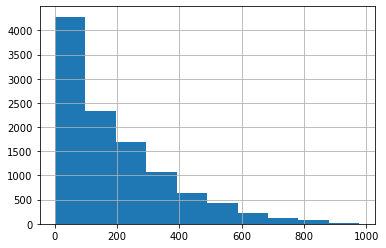

In [8]:
y_target.hist()

- count 컬럼 값이 정규 분포가 아닌 0~200 사이에 왜곡돼 있는 것을 알 수 있다
- 이렇게 왜곡된 값을 정규 분포 형태로 바꾸는 가장 일반적이 방법은 로그를 적용해 변환하는 것이다.
- 여기에서 넘파이의 log1p()를 이용하겠다.

+ 이렇게 변경된 Target 값을 기반으로 학습하고 예측한 값은 다시 expm1()함수를 적용해 원래 scale값으로 원상 복구하면 됩니다.

<AxesSubplot:>

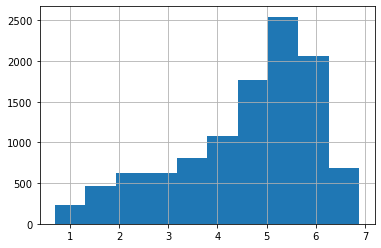

In [9]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [10]:
# 타깃 컬럼인 count 값을 log1p로 Log변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이트 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로변환
y_test_exp = np.expm1(y_test)

# 예측 값역시 Log 변환되 타겟 기반으로 학습되어 예측되었으므로 다시 exmp1으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE : 1.017, RMSE : 162.594, MAE : 109.286


- RMSLE 오류는 줄어들었지만 RMSE는 오히려 더 늘었다. 이유는 무엇일까? 각 피처의 회귀 계수 값을 시각화 해보겠다.

<AxesSubplot:>

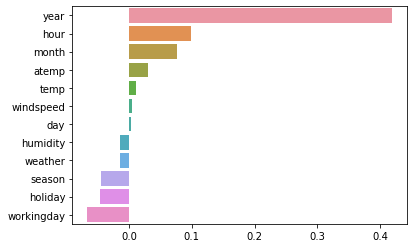

In [11]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

- Year 피처의 회귀 계수값이 독보적으로 큰 값을 가지고 있다. year는 2011년, 2012년 두 개의 값으로 돼 있다. year에 따라서 자전거 대여 횟수가 크게 영향을 받는다는 것은 납든하기 어렵다. 
- 사이킷런은 카테고리만을 위한 데이터 타입이 없으며 모두 숫자로 변환해야 한다. 하지만 이처럼 숫자형 카테고리 값을 선형 회귀에 사용할 경우 회귀 계수를 연산할 때 이 숫자형 값에 크게 영향을 받는 경우가 발생할 수 잇다.
- 따라서 선형 회귀에서는 이러한 피처 인코딩에 원-핫 인코딩을 적용해 변환해야 한다.

+ 판다스의 get_dummies()를 이용해 이러한 year칼럼을 비롯해 month, day, hour, holiday, workingday, season, weather컬럼도 모두 원-핫 인코딩한 후 다시 예측 성능을 확인해 보겠습니다.

In [16]:
# 'year','month','hour','season','weather' feature들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year','month','hour', 'holiday',
                                              'workingday','season','weather'])

In [17]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict    

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE : 0.589, RMSE : 97.485, MAE : 63.107
### Ridge ###
RMSLE : 0.589, RMSE : 98.407, MAE : 63.648
### Lasso ###
RMSLE : 0.634, RMSE : 113.031, MAE : 72.658


<AxesSubplot:>

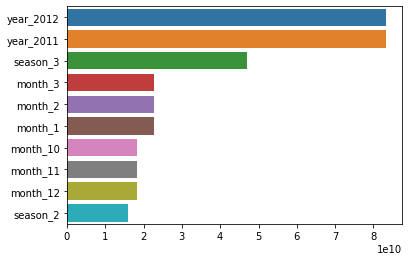

In [18]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

In [19]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### RandomForestRegressor ###
RMSLE : 0.353, RMSE : 50.817, MAE : 31.527
### GradientBoostingRegressor ###
RMSLE : 0.341, RMSE : 55.781, MAE : 34.343
### XGBRegressor ###
RMSLE : 0.339, RMSE : 50.950, MAE : 30.891
### LGBMRegressor ###
RMSLE : 0.316, RMSE : 46.473, MAE : 28.777
